In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

import sys
sys.setrecursionlimit(10**6)

In [2]:
def knn(X, k):
    """
    source: https://nycdatascience.com/blog/student-works/machine-learning/knn-classifier-from-scratch-numpy-only/
    @param X:
    @param k:
    @return:
    """
    # Calculate the euclidean distances
    distances = -2 * X @ X.T + np.sum(X ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]

    # Avoid negative numbers due to numeric error
    distances[distances < 0] = 0

    distances = np.sqrt(distances)
    indices = np.argsort(distances, 0)
    distances = np.sort(distances, 0)

    return indices[1:k + 1, :], distances[1:k + 1, :]

def eps_ball(X, eps):
    # Calculate the euclidean distances
    distances = -2 * X @ X.T + np.sum(X ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]

    # Avoid negative numbers due to numeric error
    distances[distances < 0] = 0

    distances = np.sqrt(distances)

    mask = np.where(distances < eps, 0, 1)

    # distances = np.where(distances < eps, distances, float('inf'))

    indices = np.argsort(distances, 0)
    mask = np.take_along_axis(mask, indices, 0)
    distances = np.sort(distances, 0)

    indices = np.ma.masked_array(indices, mask=mask)
    distances = np.ma.masked_array(distances, mask=mask)

    return indices[1:], distances[1:]

In [3]:
def traverse(u, visited, indices):
    visited[u] = 1
    ind = indices[:, u]
    if np.ma.is_masked(ind):
        ind = ind.compressed()
    for v in ind:
        if not visited[v]:
            traverse(v, visited, indices)


def is_connected(indices):
    n = indices.shape[1]
    visited = np.zeros(n)
    for i in range(n):
        visited = np.zeros(n)
        traverse(i, visited, indices)
        if not np.all(visited == 1):
            return False
        else:
            return True

In [95]:
def lle(X, m, n_rule, k=None, tol=1e-3, epsilon=None):
    """

    @param X: data points (nxd)
    @param m: dimension of the embedding
    @param n_rule: method used for the neighbour graph creation. options: 'knn', 'eps-ball'
    @param k: number of neighbors
    @param tol: regularization parameter for the local covariance matrices
    @param epsilon:
    @return:
    """
    print('Step 1: Finding the nearest neighbours by rule ' + n_rule)

    if n_rule == "knn":
        if(k is None):
            raise ValueError('k must be set if rule "knn" is chosen')
        elif(k>len(X)):
            raise ValueError('k may not exceed the total amount of datapoints, which is ' + len(X))
        indices, distances = knn(X, k)

    elif n_rule == 'eps-ball':
        if(epsilon is None):
            raise ValueError('epsilon must be set if rule "eps-ball" is chosen')
        indices, distances = eps_ball(X, epsilon)
    else:
        raise ValueError('Only knn and eps-ball are excepted as n_rule')

    if not is_connected(indices):
        raise ValueError('The resulted graph is not connected')

    print('Step 2: local reconstruction weights')

    # Initialize matrix of reconstruction weights
    n, d = X.shape
    W = np.zeros([n, n])

    # regularlizer only in case constrained fits are ill conditioned
    if n_rule == "knn" and k <= d:
        tol = 0

    for i in range(n):
        if n_rule == 'eps-ball':
            ind = indices[:, i].compressed()
            k = indices[:, i].count()
        else:
            ind = indices[:, i]

        # shift ith pt to origin
        z = X[ind] - np.tile(X[i], (k, 1))

        # local covariance
        C = z @ z.T

        # regularlization (K>D)
        C = C + np.eye(k) * tol * np.trace(C)

        # solve Cw=1
        w = np.squeeze(la.solve(C, np.ones((k, 1))))

        # enforce sum(w)=1
        w = w / np.sum(w)
        W[i, ind] = np.squeeze(w)


    print('Step 3: compute embedding')

    M = np.eye(n) - W
    M = M.T @ M

    D, V = la.eigh(M)
    Y = V[:,1:m+1]

    return Y

In [190]:
fishbowl = np.load('data/fishbowl_dense/X.npy')
swissroll = np.load('data/swissroll_data/x_noisefree.npy')

<function matplotlib.pyplot.show(*args, **kw)>

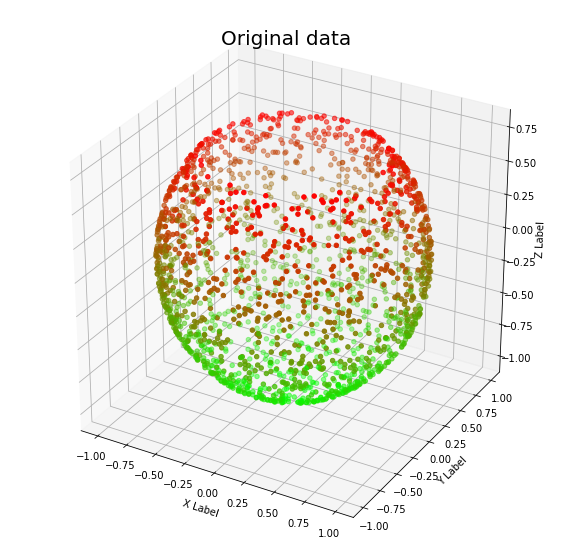

In [83]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fishbowl[0], fishbowl[1], fishbowl[2], marker='o', c=(fishbowlC.T))
ax.set_title('Original data', fontsize=20)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show

In [187]:
fishbowlEmbd = lle(fishbowl.T, 2, 'knn', k=20)
#fishbowlEmbd = lle(fishbowl.T, 2, 'eps-ball', epsilon=.25)

Step 1: Finding the nearest neighbours by rule knn
Step 2: local reconstruction weights
Step 3: compute embedding


In [188]:
maxRef = np.max(fishbowl.T[:,2]) - np.min(fishbowl.T[:,2])
minVal = abs(np.min(fishbowl.T[:,2]))
fishbowlC = np.array([(minVal+fishbowl.T[:,2])/maxRef, 1-((minVal+fishbowl.T[:,2])/maxRef), np.zeros(len(fishbowl.T))])
fishbowlC = fishbowlC[:][:]

<function matplotlib.pyplot.show(*args, **kw)>

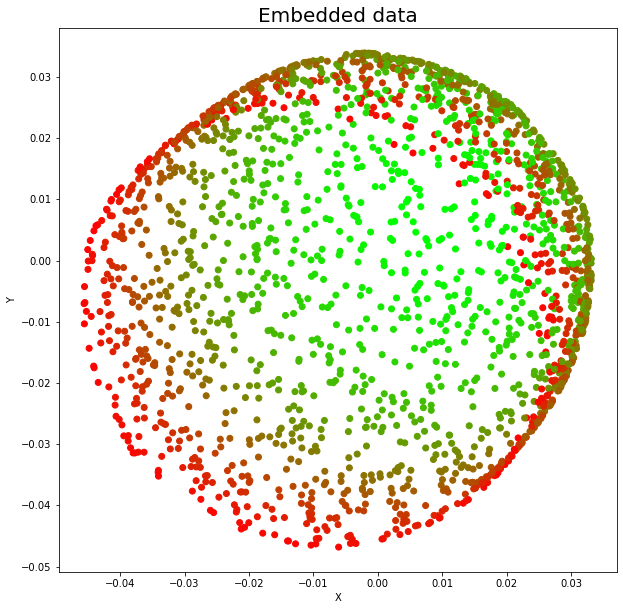

In [189]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(fishbowlEmbd.T[0], fishbowlEmbd.T[1], c=(fishbowlC.T))
ax.set_title('Embedded data', fontsize=20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show

In [195]:
maxRef = np.max(swissroll.T[:,0]) - np.min(swissroll.T[:,0])
minVal = abs(np.min(swissroll.T[:,0]))
swissrollC = np.array([(minVal+swissroll.T[:,0])/maxRef, 1-((minVal+swissroll.T[:,0])/maxRef), np.zeros(len(swissroll.T))])
swissrollC = swissrollC[:][:]

<function matplotlib.pyplot.show(*args, **kw)>

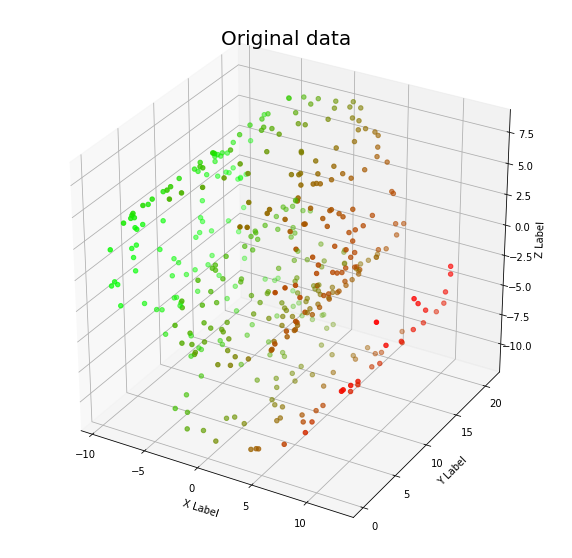

In [196]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(swissroll[0], swissroll[1], swissroll[2], marker='o', c=(swissrollC.T))
ax.set_title('Original data', fontsize=20)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show

Step 1: Finding the nearest neighbours by rule knn
Step 2: local reconstruction weights
Step 3: compute embedding
Step 1: Finding the nearest neighbours by rule knn
Step 2: local reconstruction weights
Step 3: compute embedding
Step 1: Finding the nearest neighbours by rule eps-ball
Step 2: local reconstruction weights
Step 3: compute embedding
Step 1: Finding the nearest neighbours by rule eps-ball
Step 2: local reconstruction weights
Step 3: compute embedding


<function matplotlib.pyplot.show(*args, **kw)>

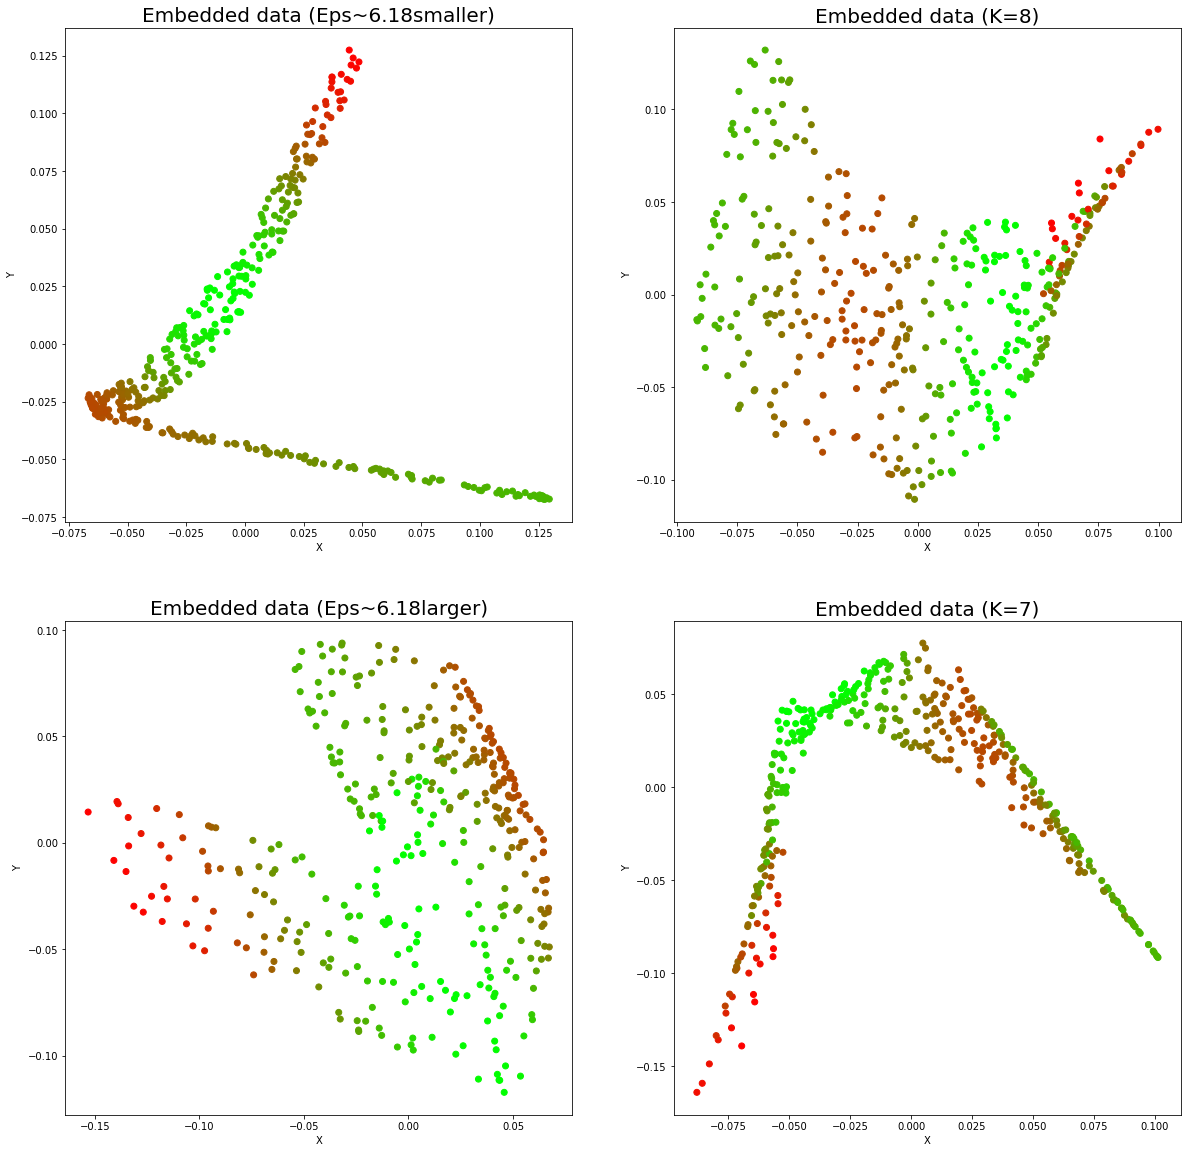

In [321]:
swissrollEmbdKnn7 = lle(swissroll.T, 2, 'knn', k=7)
swissrollEmbdKnn8 = lle(swissroll.T, 2, 'knn', k=8)
swissrollEmbdLin = lle(swissroll.T, 2, 'eps-ball', epsilon=6.1828393572091280283)  #Jump from here
swissrollEmbdPlan = lle(swissroll.T, 2, 'eps-ball', epsilon=6.1828393572091280284) #to here
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
ax[0,0].scatter(swissrollEmbdLin.T[0], swissrollEmbdLin.T[1], c=(swissrollC.T))
ax[0,0].set_title('Embedded data (Eps~6.18smaller)', fontsize=20)
ax[0,0].set_xlabel('X')
ax[0,0].set_ylabel('Y')
ax[1,0].scatter(swissrollEmbdPlan.T[0], swissrollEmbdPlan.T[1], c=(swissrollC.T))
ax[1,0].set_title('Embedded data (Eps~6.18larger)', fontsize=20)
ax[1,0].set_xlabel('X')
ax[1,0].set_ylabel('Y')

ax[0,1].scatter(swissrollEmbdKnn8.T[0], swissrollEmbdKnn8.T[1], c=(swissrollC.T))
ax[0,1].set_title('Embedded data (K=8)', fontsize=20)
ax[0,1].set_xlabel('X')
ax[0,1].set_ylabel('Y')
ax[1,1].scatter(swissrollEmbdKnn7.T[0], swissrollEmbdKnn7.T[1], c=(swissrollC.T))
ax[1,1].set_title('Embedded data (K=7)', fontsize=20)
ax[1,1].set_xlabel('X')
ax[1,1].set_ylabel('Y')

plt.show

(3, 400)